# Drilling Activity Prediction

## Content
- Obtain data from EIA (Energy Information Administration)
- Build DataFrame with data obtained from EIA

## Obtain data from EIA (Energy Information Administration)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

API Overview

In [2]:
EIA_key = "62d3f57124e55b9d33ac4c6fbf7f0014"
url = "http://api.eia.gov/category/?api_key="+EIA_key+"&category_id=371"
response = requests.get(url)
data_raw = response.json()

In [3]:
data_raw

{'request': {'category_id': 371, 'command': 'category'},
 'category': {'category_id': '371',
  'parent_category_id': None,
  'name': 'EIA Data Sets',
  'notes': '',
  'childcategories': [{'category_id': 0, 'name': 'Electricity'},
   {'category_id': 40203, 'name': 'State Energy Data System (SEDS)'},
   {'category_id': 714755, 'name': 'Petroleum'},
   {'category_id': 714804, 'name': 'Natural Gas'},
   {'category_id': 711224, 'name': 'Total Energy'},
   {'category_id': 717234, 'name': 'Coal'},
   {'category_id': 829714, 'name': 'Short-Term Energy Outlook'},
   {'category_id': 964164, 'name': 'Annual Energy Outlook'},
   {'category_id': 1292190, 'name': 'Crude Oil Imports'},
   {'category_id': 2123635, 'name': 'U.S. Electric System Operating Data'},
   {'category_id': 2134384, 'name': 'International Energy Data'},
   {'category_id': 2251604, 'name': 'CO2 Emissions'},
   {'category_id': 2631064, 'name': 'International Energy Outlook'},
   {'category_id': 2889994, 'name': 'U.S. Nuclear Outag

API Data download Example: Obtain Oil Price in USD/bbl in time

In [4]:
seriesid = 'PET.RWTC.D'
response2 = requests.get('http://api.eia.gov/series/?api_key='+EIA_key+'&series_id='+seriesid)
API_data = response2.json()

In [5]:
for key in ['name','description','units','source','start','end','updated']:
    print(key+":     ", API_data['series'][0].get(key))

name:      Cushing, OK WTI Spot Price FOB, Daily
description:      Cushing, OK WTI Spot Price FOB
units:      Dollars per Barrel
source:      Thomson-Reuters
start:      19860102
end:      20211012
updated:      2021-10-14T13:41:06-0400


In [6]:
API_data['series'][0]['data'][:10]

[['20211012', 80.75],
 ['20211008', 79.55],
 ['20211007', 78.46],
 ['20211006', 77.66],
 ['20211005', 79.17],
 ['20211004', 77.68],
 ['20211001', 76.01],
 ['20210930', 75.22],
 ['20210929', 75.06],
 ['20210928', 75.44]]

In [7]:
oil = pd.DataFrame(
    columns=['date','oil_price'],
    data=np.array([API_data['series'][0]['data']][0])
)
oil['date'] = pd.to_datetime(oil['date'],format='%Y%m%d')
oil['oil_price'] = oil['oil_price'].astype('float')
oil.head()

,date,oil_price
0,2021-10-12,80.75
1,2021-10-08,79.55
2,2021-10-07,78.46
3,2021-10-06,77.66
4,2021-10-05,79.17


Function to download tables from API and convert into pandas data frames

In [8]:
def download_convert(seriesid='',timeformat='%Y%m%d',column1='col1',column2='col2'):
    data = requests.get('http://api.eia.gov/series/?api_key='+EIA_key+'&series_id='+seriesid).json()
    for key in ['name','description','units','source','start','end','updated']:
        print(key+":     ", data['series'][0].get(key))
    df = pd.DataFrame(
        columns=[column1,column2],
        data=np.array([data['series'][0]['data']][0]))
    df[column1] = pd.to_datetime(df[column1],format=timeformat)
    df[column2] = df[column2].replace({'NA':np.nan}) if df[(df[column2] == 'NA')][column2].count() > 0 else df[column2]
    df[column2] = df[column2].astype('float')    
    return(df)

Obtain Gas Price in USD/MMBTU cubic feet in time

In [9]:
gas = download_convert('NG.RNGWHHD.D',timeformat='%Y%m%d',column1='date',column2='gas_price')
gas.rename(columns={'var1':'gas_date', 'var2':'gas_price'},inplace=True)
gas.head()

name:      Henry Hub Natural Gas Spot Price, Daily
description:      Henry Hub Natural Gas Spot Price
units:      Dollars per Million Btu
source:      Thomson-Reuters
start:      19970107
end:      20211013
updated:      2021-10-14T13:41:06-0400


,date,gas_price
0,2021-10-13,5.56
1,2021-10-12,5.34
2,2021-10-08,5.46
3,2021-10-07,5.71
4,2021-10-06,6.00


Rotary Rig Count in time

In [10]:
OilRig = download_convert(seriesid='TOTAL.PANRPUS.M',timeformat='%Y%m',column1='date',column2='oilrig_count')
OilRig.head()

name:      Crude Oil Rotary Rigs in Operation, Monthly
description:      None
units:      Number of Rigs
source:      None
start:      197301
end:      202108
updated:      2021-09-23T14:20:33-0400


,date,oilrig_count
0,2021-08-01,400.0
1,2021-07-01,381.0
2,2021-06-01,367.0
3,2021-05-01,353.0
4,2021-04-01,341.0


In [11]:
GasRig = download_convert(seriesid='TOTAL.NGNRPUS.M',timeformat='%Y%m',column1='date',column2='gasrig_count')
GasRig.head()

name:      Natural Gas Rotary Rigs in Operation, Monthly
description:      None
units:      Number of Rigs
source:      None
start:      197301
end:      202108
updated:      2021-09-23T14:20:33-0400


,date,gasrig_count
0,2021-08-01,100.0
1,2021-07-01,102.0
2,2021-06-01,97.0
3,2021-05-01,100.0
4,2021-04-01,94.0


In [12]:
OnshoreRig = download_convert(seriesid='TOTAL.OGNRPON.M',timeformat='%Y%m',column1='date',column2='onshore_count')
OnshoreRig.head()

name:      Crude Oil and Natural Gas Rotary Rigs in Operation, Onshore, Monthly
description:      None
units:      Number of Rigs
source:      None
start:      197301
end:      202108
updated:      2021-09-23T14:20:33-0400


,date,onshore_count
0,2021-08-01,486.0
1,2021-07-01,468.0
2,2021-06-01,451.0
3,2021-05-01,439.0
4,2021-04-01,424.0


In [13]:
OffshoreRig = download_convert(seriesid='TOTAL.OGNRPOF.M',timeformat='%Y%m',column1='date',column2='offshore_count')
OffshoreRig.head()

name:      Crude Oil and Natural Gas Rotary Rigs in Operation, Offshore, Monthly
description:      None
units:      Number of Rigs
source:      None
start:      197301
end:      202108
updated:      2021-09-23T14:20:33-0400


,date,offshore_count
0,2021-08-01,15.0
1,2021-07-01,16.0
2,2021-06-01,13.0
3,2021-05-01,14.0
4,2021-04-01,12.0


In [14]:
TotalRig = download_convert(seriesid='TOTAL.OGNRPUS.M',timeformat='%Y%m',column1='date',column2='totalrig_count')
TotalRig.head()

name:      Crude Oil and Natural Gas Rotary Rigs in Operation, Total, Monthly
description:      None
units:      Number of Rigs
source:      None
start:      197301
end:      202108
updated:      2021-09-23T14:20:33-0400


,date,totalrig_count
0,2021-08-01,501.0
1,2021-07-01,483.0
2,2021-06-01,464.0
3,2021-05-01,453.0
4,2021-04-01,436.0


## Oil, gas and Dry Wells Drilled in time

In [15]:
TotalWells = download_convert(seriesid='TOTAL.OGTWPUS.M',timeformat='%Y%m',column1='date',column2='totalwell_count')
TotalWells.head()

name:      Crude Oil, Natural Gas, and Dry Wells Drilled, Total, Monthly
description:      None
units:      Number of Wells
source:      None
start:      197301
end:      201212
updated:      2016-04-25T13:57:43-0400


,date,totalwell_count
0,2010-12-01,3158.0
1,2010-11-01,3294.0
2,2010-10-01,3527.0
3,2010-09-01,3218.0
4,2010-08-01,3404.0


In [16]:
OilWells = download_convert(seriesid='TOTAL.PATWPUS.M',timeformat='%Y%m',column1='date',column2='oilwell_count')
OilWells.head()

name:      Wells Drilled, Total, Crude Oil, Monthly
description:      None
units:      Number of Wells
source:      None
start:      197301
end:      201212
updated:      2016-04-25T13:57:43-0400


,date,oilwell_count
0,2010-12-01,1374.0
1,2010-11-01,1462.0
2,2010-10-01,1577.0
3,2010-09-01,1431.0
4,2010-08-01,1490.0


In [17]:
GasWells = download_convert(seriesid='TOTAL.NGTWPUS.M',timeformat='%Y%m',column1='date',column2='gaswell_count')
GasWells.head()

name:      Wells Drilled, Total, Natural Gas, Monthly
description:      None
units:      Number of Wells
source:      None
start:      197301
end:      201212
updated:      2016-04-25T13:57:43-0400


,date,gaswell_count
0,2010-12-01,1471.0
1,2010-11-01,1466.0
2,2010-10-01,1550.0
3,2010-09-01,1431.0
4,2010-08-01,1506.0


## Natural Gas Imports, Exports, consumption, Production and storage

In [18]:
GasImports = download_convert(seriesid='TOTAL.NGIMPUS.M',timeformat='%Y%m',column1='date',column2='gasimports_amount')
GasImports.head()

name:      Natural Gas Imports, Monthly
description:      None
units:      Billion Cubic Feet
source:      None
start:      197301
end:      202106
updated:      2021-09-23T14:20:33-0400


,date,gasimports_amount
0,2021-06-01,207.242
1,2021-05-01,204.890
2,2021-04-01,208.369
3,2021-03-01,238.787
4,2021-02-01,271.961


In [19]:
GasExports = download_convert(seriesid='TOTAL.NGEXPUS.M',timeformat='%Y%m',column1='date',column2='gasexports_amount')
GasExports.head()

name:      Total Natural Gas Exports, Monthly
description:      None
units:      Billion Cubic Feet
source:      None
start:      197301
end:      202106
updated:      2021-09-23T14:20:33-0400


,date,gasexports_amount
0,2021-06-01,535.650
1,2021-05-01,574.501
2,2021-04-01,560.890
3,2021-03-01,595.375
4,2021-02-01,423.972


In [20]:
GasConsumption = download_convert(seriesid='TOTAL.NGTCPUS.M',timeformat='%Y%m',column1='date',column2='gasconsumption_amount')
GasConsumption.head()

name:      Natural Gas Consumption, Total, Monthly
description:      None
units:      Billion Cubic Feet
source:      None
start:      197301
end:      202106
updated:      2021-09-23T14:20:33-0400


,date,gasconsumption_amount
0,2021-06-01,2218.011
1,2021-05-01,2100.668
2,2021-04-01,2245.503
3,2021-03-01,2608.166
4,2021-02-01,3034.403


In [21]:
#weekly NG.NGM_EPG0_FGW_NUS_MMCFD.M
GasProduction = download_convert(seriesid='TOTAL.NGELPUS.M',timeformat='%Y%m',column1='date',column2='gasproduction_amount')
GasProduction.head()

name:      NGPL Production, Monthly
description:      None
units:      Billion Cubic Feet
source:      None
start:      197301
end:      202106
updated:      2021-09-23T14:20:33-0400


,date,gasproduction_amount
0,2021-06-01,237.703
1,2021-05-01,244.674
2,2021-04-01,236.817
3,2021-03-01,228.828
4,2021-02-01,170.302


In [22]:
GasStorage = download_convert(seriesid='TOTAL.NGUSPUS.M',timeformat='%Y%m',column1='date',column2='gasstorage_amount')
GasStorage.head()

name:      Natural Gas in Underground Storage, End of Period, Total, Monthly
description:      None
units:      Billion Cubic Feet
source:      None
start:      197301
end:      202106
updated:      2021-09-23T14:20:33-0400


,date,gasstorage_amount
0,2021-06-01,7018.692
1,2021-05-01,6770.915
2,2021-04-01,6354.239
3,2021-03-01,6188.654
4,2021-02-01,6247.841


## Oil Imports, Exports, consumption, Production, storage and storage oil change

In [23]:
#'TOTAL.PAIMPUS.M'
# 'PET.WTTIMUS2.W'
OilImports_a = download_convert(seriesid='TOTAL.PAIMPUS.M',timeformat='%Y%m',column1='date',column2='oilimports_amount_x')
print('\n')
OilImports_b = download_convert(seriesid='PET.WTTIMUS2.W',timeformat='%Y%m%d',column1='date',column2='oilimports_amount_y')

name:      Total Petroleum Imports, Monthly
description:      None
units:      Thousand Barrels per Day
source:      None
start:      197301
end:      202108
updated:      2021-09-23T14:20:33-0400


name:      U.S. Imports of Crude Oil and Petroleum Products, Weekly
description:      U.S. Imports of Crude Oil and Petroleum Products
units:      Thousand Barrels per Day
source:      EIA, U.S. Energy Information Administration
start:      19910208
end:      20211008
updated:      2021-10-14T13:41:06-0400


In [24]:
# For future use (EDA)
# OilImports['oilimports_amount'] = OilImports['oilimports_amount_x']
# OilImports.loc[OilImports['oilimports_amount'].isnull() == True,'oilimports_amount'] = OilImports['oilimports_amount_y']
# OilImports[OilImports['oilimports_amount'].isna() == False][:]

In [25]:
#'PET.WTTEXUS2.W'
#'TOTAL.PAEXPUS.M'
OilExports_a = download_convert(seriesid='TOTAL.PAEXPUS.M',timeformat='%Y%m',column1='date',column2='oilexports_amount_x')
print('\n')
OilExports_b = download_convert(seriesid='PET.WTTEXUS2.W',timeformat='%Y%m%d',column1='date',column2='oilexports_amount_y')

name:      Total Petroleum Exports, Monthly
description:      None
units:      Thousand Barrels per Day
source:      None
start:      197301
end:      202108
updated:      2021-09-23T14:20:33-0400


name:      U.S. Exports of Crude Oil and Petroleum Products, Weekly
description:      U.S. Exports of Crude Oil and Petroleum Products
units:      Thousand Barrels per Day
source:      EIA, U.S. Energy Information Administration
start:      19910208
end:      20211008
updated:      2021-10-14T13:41:06-0400


In [26]:
#'PET.WRPUPUS2.W'
#'TOTAL.PATCPUS.M'
OilConsumption_a = download_convert(seriesid='TOTAL.PATCPUS.M',timeformat='%Y%m',column1='date',column2='oilconsumption_amount_x')
print('\n')
OilConsumption_b = download_convert(seriesid='PET.WRPUPUS2.W',timeformat='%Y%m%d',column1='date',column2='oilconsumption_amount_y')

name:      Petroleum Products Supplied/Consumption, United States, Monthly
description:      None
units:      Thousand Barrels per Day
source:      None
start:      197301
end:      202108
updated:      2021-09-23T14:20:33-0400


name:      U.S. Product Supplied of Petroleum Products, Weekly
description:      U.S. Product Supplied of Petroleum Products
units:      Thousand Barrels per Day
source:      EIA, U.S. Energy Information Administration
start:      19901109
end:      20211008
updated:      2021-10-14T13:41:06-0400


In [27]:
#monthly TOTAL.PAPRPUS.M
# weekly PET.WCRFPUS2.W
OilProduction_a = download_convert(seriesid='TOTAL.PAPRPUS.M',timeformat='%Y%m',column1='date',column2='oilproduction_amount_x')
print('\n')
OilProduction_b = download_convert(seriesid='PET.WCRFPUS2.W',timeformat='%Y%m%d',column1='date',column2='oilproduction_amount_y')

name:      Crude Oil Production, Total, Monthly
description:      None
units:      Thousand Barrels per Day
source:      None
start:      197301
end:      202108
updated:      2021-09-23T14:20:33-0400


name:      U.S. Field Production of Crude Oil, Weekly
description:      U.S. Field Production of Crude Oil
units:      Thousand Barrels per Day
source:      EIA, U.S. Energy Information Administration
start:      19830107
end:      20211008
updated:      2021-10-14T13:41:06-0400


In [28]:
#weekly PET.WTTSTUS1.W
#monthly TOTAL.COPSPUS.M
OilStorage_a = download_convert(seriesid='TOTAL.COPSPUS.M',timeformat='%Y%m',column1='date',column2='oilstorage_amount_x')
print('\n')
OilStorage_b = download_convert(seriesid='PET.WCRSTUS1.W',timeformat='%Y%m%d',column1='date',column2='oilstorage_amount_y')

name:      Crude Oil Stocks, Total, End of Period, Monthly
description:      None
units:      Million Barrels
source:      None
start:      197301
end:      202108
updated:      2021-09-23T14:20:33-0400


name:      U.S. Ending Stocks of Crude Oil, Weekly
description:      U.S. Ending Stocks of Crude Oil
units:      Thousand Barrels
source:      EIA, U.S. Energy Information Administration
start:      19820820
end:      20211008
updated:      2021-10-14T13:41:06-0400


In [29]:
#'PET.WTTSTUS1.W'
#'PET.MCRSCUS1.M'
OilStorageChange = download_convert(seriesid='PET.MCRSCUS1.M',timeformat='%Y%m',column1='date',column2='oilstoragechange_amount')
OilStorageChange.head()

name:      U.S. Crude Oil Stock Change, Monthly
description:      U.S. Crude Oil Stock Change
units:      Thousand Barrels
source:      EIA, U.S. Energy Information Administration
start:      198101
end:      202107
updated:      2021-09-30T13:01:56-0400


,date,oilstoragechange_amount
0,2021-07-01,-9035.0
1,2021-06-01,-34924.0
2,2021-05-01,-18979.0
3,2021-04-01,-16518.0
4,2021-03-01,8748.0


Days of Supply of Crude Oil

In [30]:
# PET.W_EPC0_VSD_NUS_DAYS.W
OilDaysOfSupply = download_convert(seriesid='PET.W_EPC0_VSD_NUS_DAYS.W',timeformat='%Y%m%d',column1='date',column2='oildaysofsupply')
OilDaysOfSupply.head()

name:      U.S. Days of Supply of Crude Oil excluding SPR, Weekly
description:      U.S. Days of Supply of Crude Oil excluding SPR
units:      Number of Days
source:      EIA, U.S. Energy Information Administration
start:      19820924
end:      20211008
updated:      2021-10-14T13:41:06-0400


,date,oildaysofsupply
0,2021-10-08,27.7
1,2021-10-01,27.6
2,2021-09-24,28.2
3,2021-09-17,27.6
4,2021-09-10,27.5


US Resident Population

In [31]:
USPopulation = download_convert(seriesid='SEDS.TPOPP.US.A',timeformat='%Y',column1='date',column2='uspopulation')
USPopulation.head()

name:      Resident population including Armed Forces, United States
description:      Resident population including Armed Forces, United States See http://www.eia.gov/state/seds/seds-technical-notes-complete.cfm?sid=US for technical notes and documentation.
units:      Thousand
source:      SEDS, EIA, U.S. Energy Information Administration
start:      1960
end:      2019
updated:      2021-06-24T19:29:04-0400


,date,uspopulation
0,2019-01-01,328330.0
1,2018-01-01,326838.0
2,2017-01-01,325122.0
3,2016-01-01,323072.0
4,2015-01-01,320739.0


CO2 Emissions

In [32]:
#EMISS.CO2-TOTV-TT-PE-US.A
USEmissions = download_convert(seriesid='EMISS.CO2-TOTV-TT-PE-US.A',timeformat='%Y',column1='date',column2='usemissions')
USEmissions.head()

name:      Total carbon dioxide emissions from all sectors, petroleum, United States
description:      See http://www.eia.gov/environment/emissions/state/analysis/ for technical notes and documentation.
units:      million metric tons CO2
source:      EIA, U.S. Energy Information Administration
start:      1980
end:      2018
updated:      2021-10-14T16:18:55-0400


,date,usemissions
0,2018-01-01,2379.897795
1,2017-01-01,2336.884160
2,2016-01-01,2314.860364
3,2015-01-01,2284.230588
4,2014-01-01,2244.002699


## Build DataFrame with data obtained from EIA

In [33]:
df = pd.merge(left=oil,right=gas, how='left',on='date')

In [34]:
df_list = [OilRig,GasRig,TotalRig,OnshoreRig,OffshoreRig,TotalWells, OilWells, GasWells,
           OilImports_a,OilImports_b,OilExports_a,OilExports_b,OilProduction_a,OilProduction_b,
           OilConsumption_a,OilConsumption_b,OilStorage_a,OilStorage_b, OilStorageChange,OilDaysOfSupply,
           GasImports,GasExports,GasProduction,GasConsumption,GasStorage, 
            USPopulation,USEmissions]

In [35]:
for data in range(len(df_list)):    
    df = pd.merge(left=df,right=df_list[data],how='outer',on='date')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9588 entries, 0 to 9587
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     9588 non-null   datetime64[ns]
 1   oil_price                9028 non-null   float64       
 2   gas_price                6212 non-null   float64       
 3   oilrig_count             409 non-null    float64       
 4   gasrig_count             409 non-null    float64       
 5   totalrig_count           584 non-null    float64       
 6   onshore_count            584 non-null    float64       
 7   offshore_count           584 non-null    float64       
 8   totalwell_count          456 non-null    float64       
 9   oilwell_count            456 non-null    float64       
 10  gaswell_count            456 non-null    float64       
 11  oilimports_amount_x      584 non-null    float64       
 12  oilimports_amount_y      1601 non-

In [37]:
df.describe()

,oil_price,gas_price,oilrig_count,gasrig_count,totalrig_count,onshore_count,offshore_count,totalwell_count,oilwell_count,gaswell_count,...,oilstorage_amount_y,oilstoragechange_amount,oildaysofsupply,gasimports_amount,gasexports_amount,gasproduction_amount,gasconsumption_amount,gasstorage_amount,uspopulation,usemissions
count,9028.000000,6212.000000,409.000000,409.000000,584.000000,584.000000,584.000000,456.000000,456.000000,456.000000,...,2.037000e+03,487.000000,2035.000000,582.000000,582.000000,582.000000,582.000000,553.000000,60.000000,39.000000
mean,44.480035,4.148232,497.638142,586.156479,1390.761986,1286.397260,104.388699,3482.348684,1363.824561,1259.942982,...,9.452759e+05,1206.186858,23.416118,202.998770,70.439296,91.307146,1851.265686,6492.789405,253787.633333,2269.590735
std,28.718434,2.180311,361.820717,388.729151,746.262477,705.073985,63.554555,1654.495630,898.651676,626.667629,...,1.235395e+05,11206.982092,4.054500,103.105458,111.209765,40.387271,472.992189,829.360748,44937.791475,162.139103
min,-36.980000,0.000000,108.000000,70.000000,250.000000,237.000000,12.000000,1268.000000,291.000000,454.000000,...,6.077810e+05,-34924.000000,16.100000,42.512000,1.614000,59.000000,939.930000,4446.000000,180671.000000,1978.171074
25%,19.867500,2.640000,253.000000,325.000000,844.000000,742.000000,55.750000,2288.500000,755.000000,771.750000,...,8.668890e+05,-6943.000000,20.500000,92.581500,5.817750,70.000000,1515.522750,5876.197000,215443.250000,2165.559919
50%,33.180000,3.480000,373.000000,461.000000,1118.500000,1036.000000,99.000000,2913.500000,1031.000000,1107.500000,...,9.076370e+05,1107.000000,23.000000,218.786000,14.389000,76.059500,1764.327500,6496.755000,248221.000000,2245.027707
75%,63.552500,5.162500,643.000000,864.000000,1810.250000,1716.000000,127.250000,4208.500000,1518.250000,1552.000000,...,1.043946e+06,8567.500000,25.400000,285.724750,89.924000,85.872750,2161.833500,7075.486000,293483.000000,2380.083701
max,145.310000,23.860000,1596.000000,1585.000000,4521.000000,4238.000000,283.000000,8556.000000,3945.000000,3200.000000,...,1.227678e+06,48553.000000,42.000000,426.534000,595.375000,244.674000,3417.277000,8384.087000,328330.000000,2594.010731


In [38]:
df[(df['date'].dt.year == 1981)&(df['date'].dt.month == 8)]['totalrig_count']

9236    4131.0
Name: totalrig_count, dtype: float64

In [39]:
df[(df['totalrig_count'] == df['totalrig_count'].max())]

,date,oil_price,gas_price,oilrig_count,gasrig_count,totalrig_count,onshore_count,offshore_count,totalwell_count,oilwell_count,...,oilstorage_amount_y,oilstoragechange_amount,oildaysofsupply,gasimports_amount,gasexports_amount,gasproduction_amount,gasconsumption_amount,gasstorage_amount,uspopulation,usemissions
9232,1981-12-01,NaN,NaN,NaN,NaN,4521.0,4238.0,283.0,8029.0,3843.0,...,NaN,5268.0,NaN,92.544,4.539,67.0,2076.436,6569.0,NaN,NaN


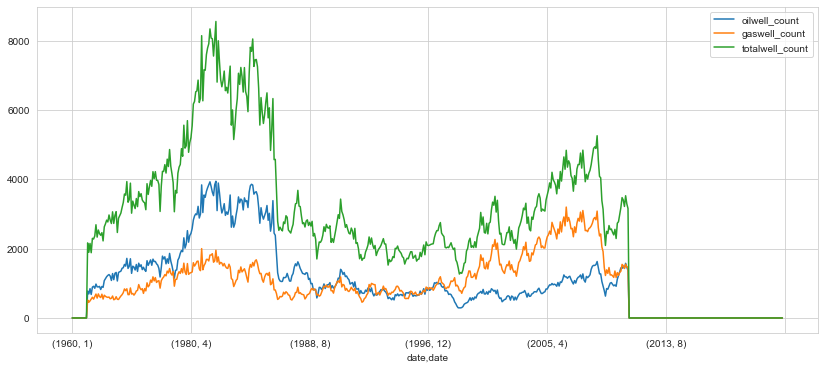

In [40]:
sns.set_style('whitegrid')
for rig_count in ['oilwell_count','gaswell_count','totalwell_count']:
    df.groupby([df['date'].dt.year,df['date'].dt.month])[rig_count].sum().plot.line(figsize=(14,6))
plt.legend() 

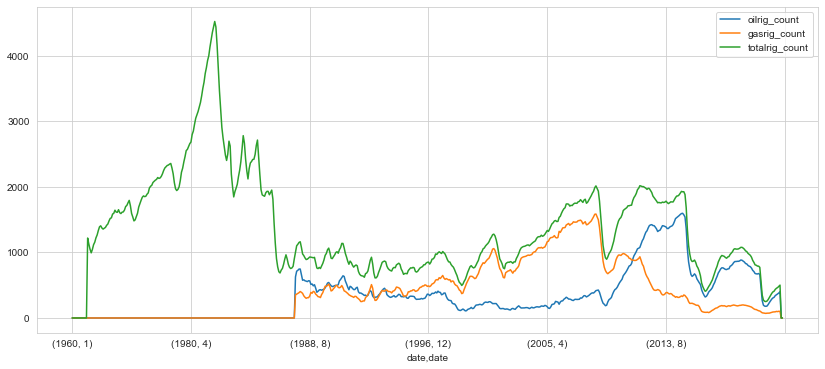

In [41]:
for rig_count in ['oilrig_count','gasrig_count','totalrig_count']:
    df.groupby([df['date'].dt.year,df['date'].dt.month])[rig_count].sum().plot.line(figsize=(14,6))
plt.legend() 

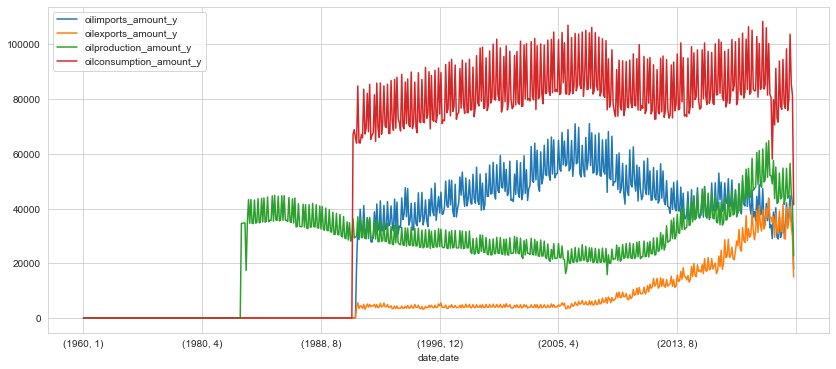

In [44]:
for feature in ['oilimports_amount_y','oilexports_amount_y','oilproduction_amount_y','oilconsumption_amount_y']:
    df.groupby([df['date'].dt.year,df['date'].dt.month])[feature].sum().plot.line(figsize=(14,6))
plt.legend() 

In [ ]:
# df.to_csv('Oil&Gas.csv')